## Installation

In [20]:
%pip install dynamsoft-barcode-reader-bundle opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Set a license key to activate Dynamsoft Barcode SDK

[![](https://img.shields.io/badge/Get-30--day%20FREE%20Trial%20License-blue)](https://www.dynamsoft.com/customer/license/trialLicense/?product=dcv&package=cross-platform)

## Upload barcode images for recognition

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

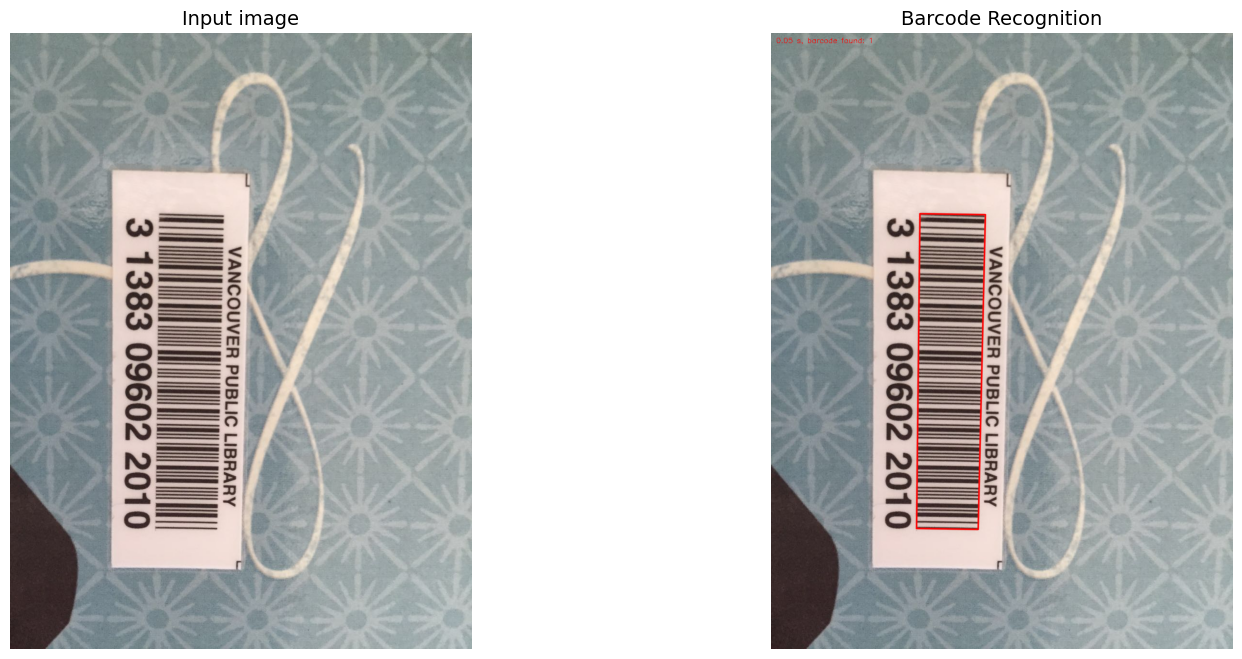

In [ ]:
from ipywidgets import FileUpload
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from dynamsoft_capture_vision_bundle import *
import time

# ---------- Dynamsoft init ----------
cvr_instance = CaptureVisionRouter()
error_code, error_message = LicenseManager.init_license(
    "DLS2eyJoYW5kc2hha2VDb2RlIjoiMjAwMDAxLTE2NDk4Mjk3OTI2MzUiLCJvcmdhbml6YXRpb25JRCI6IjIwMDAwMSIsInNlc3Npb25QYXNzd29yZCI6IndTcGR6Vm05WDJrcEQ5YUoifQ=="
)
if error_code not in (EnumErrorCode.EC_OK, EnumErrorCode.EC_LICENSE_CACHE_USED):
    print("License initialization failed: ErrorCode:", error_code, ", ErrorString:", error_message)

# ---------- Helper functions ----------
def decode(frame):
    before = time.time()
    result = cvr_instance.capture(frame, EnumPresetTemplate.PT_READ_BARCODES.value)
    after = time.time()

    COLOR_RED = (0, 0, 255)
    thickness = 2
    text_x, text_y = 10, 20

    if result.get_error_code() != EnumErrorCode.EC_OK:
        print("Error:", result.get_error_code(), result.get_error_string())
        cv.putText(frame, f'{after - before:.2f} s, barcode found: 0', (text_x, text_y),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, COLOR_RED)
        return

    items = result.get_items()
    found = len(items)
    for item in items:
        format_type = item.get_format()
        text = item.get_text()
        print(f'Format: {format_type}, Text: {text}')
        loc = item.get_location()
        pts = np.array([[p.x, p.y] for p in loc.points], dtype=np.int32)
        cv.drawContours(image=frame, contours=[pts], contourIdx=-1,
                        color=COLOR_RED, thickness=thickness, lineType=cv.LINE_AA)
        cv.putText(frame, f'{format_type}', (pts[0][0], pts[0][1] - 10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, COLOR_RED)
        cv.putText(frame, f'{text}', (pts[0][0], pts[0][1] - 30),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, COLOR_RED)
    cv.putText(frame, f'{after - before:.2f} s, barcode found: {found}', (text_x, text_y),
               cv.FONT_HERSHEY_SIMPLEX, 0.5, COLOR_RED)

def show_image(img1, img2):
    fig = plt.figure(figsize=(18, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('Input image', fontsize=14)
    ax1.axis('off')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('Barcode Recognition', fontsize=14)
    ax2.axis('off')
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.show()

def _flatten_records(obj):
    """Yield leaf records regardless of whether obj is a dict/tuple/list/mixed."""
    if obj is None:
        return
    # Old style: {filename: {content: ..., ...}, ...}
    if isinstance(obj, dict) and "content" not in obj:
        for v in obj.values():
            yield from _flatten_records(v)
        return
    if isinstance(obj, (list, tuple)):
        for v in obj:
            yield from _flatten_records(v)
        return
    # Leaf (either UploadedFile or dict with 'content')
    yield obj

def _get_bytes(rec):
    """Extract bytes for any record shape."""
    # UploadedFile in ipywidgets>=8
    if hasattr(rec, "content"):
        return rec.content
    # Dict with 'content'
    if isinstance(rec, dict) and "content" in rec:
        return rec["content"]
    raise TypeError(f"Unsupported upload record type: {type(rec)}")

# ---------- Upload handler ----------
def on_upload_change(change):
    if change.name != "value":
        return
    if not change.new:
        return

    up = change.owner
    files_obj = change.new

    # Normalize to iterable of records
    records = list(_flatten_records(files_obj))

    for rec in records:
        try:
            content = _get_bytes(rec)  # bytes
        except Exception as e:
            print("Skip unsupported record:", e)
            continue

        buf = np.frombuffer(content, dtype=np.uint8)
        img = cv.imdecode(buf, cv.IMREAD_COLOR)
        if img is None:
            print("Failed to decode image.")
            continue

        new_img = img.copy()
        try:
            decode(new_img)
        except Exception as e:
            print("Decode error:", e)

        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        new_rgb = cv.cvtColor(new_img, cv.COLOR_BGR2RGB)
        show_image(img_rgb, new_rgb)

    # --- Safely reset the widget so the same file can be re-uploaded ---
    # Temporarily unbind to avoid recursive change events
    try:
        up.unobserve(on_upload_change, names="value")
    except Exception:
        pass

    # Try several reset strategies depending on front-end
    reset_done = False
    for val in ((), [], None):
        try:
            up.value = val
            reset_done = True
            break
        except Exception:
            continue
    if not reset_done:
        try:
            # Old dict-style supports .clear()
            up.value.clear()
            reset_done = True
        except Exception:
            pass

    # Re-bind observer
    try:
        up.observe(on_upload_change, names="value")
    except Exception:
        pass

# ---------- Widget ----------
uploader = FileUpload(accept='image/*', multiple=True)  # multiple=True works for tuple/list/dict variants
uploader.observe(on_upload_change, names="value")
uploader
